In [1]:
%matplotlib inline
import pysal as ps
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import libpysal as lps
import esda
import spreg
from patsy import dmatrices
from sklearn import preprocessing

In [36]:
##########   LAGGED X MODEL
LX=[]
cols_m=['YEAR', 'ZIP_2', 'NGROUP', 'NENTRY', 'LOCATION_Q', 'REGIONAL_I', 'FIRM_SIZE_', 'BUSINESS_C', 'AVG_WAGE', 'POP_DEN', 'POP_INC', 'POP_BLACK', 'POP_HISP', 'POP_WORK_A', 'POP_MALE', 'COLLEGE_CO', 'HIGHSCHOOL', 'UNEMPLOYME', 'NAIRPORTS', 'MED_INC', 'MED_VALUE', 'HOME_OWNER']
gdf=gpd.read_file(r"/Users/shagunmittal/Documents/research/Spatial/20_finalvars/20_finalvars.shp")
ngroups=20
initial=1990
ncomponents=3
data1=np.zeros(((len(cols_m)-9),2011-initial+1))
noweights=["REGIONAL_I","FIRM_SIZE_","BUSINESS_C"]
for cnt in range(2,ngroups+1):
    noweights.append("GG"+str(cnt))
for cnt in range(2,ngroups+1):
    cols_m.append("GG"+str(cnt))
for cnt in range(1,ngroups+1):
    for cnt2 in range(1,ncomponents+1):
        cols_m.append("F"+str(cnt)+str(cnt2))
drop=["MED_INC","POP_MALE","COLLEGE_CO"]
for cnt in drop:
    cols_m.remove(cnt)
for year in range(1992,2012):
    print(year)
    cols=cols_m
    gdf1=gdf[gdf["YEAR"]==year]
    W=lps.weights.Queen.from_dataframe(gdf1)
    for cnt in range(0,gdf1.shape[0]):
        grp = gdf1["NGROUP"].values[cnt]
        Neigh = W.neighbors[cnt]
        temp=[]
        for cnt2 in range(0,len(Neigh)):
            grp2 = gdf1["NGROUP"].values[Neigh[cnt2]]
            if grp!=grp2:
                temp.append(Neigh[cnt2])
        for cnt2 in temp:
            (W.neighbors[cnt]).remove(cnt2)
    cneighbors=W.neighbors
    cweights = {}
    for key, value in cneighbors.items():
        cweights[key] = (np.ones_like(value)/len(value)).tolist()
    w2 = lps.weights.W(cneighbors, cweights)
    ##### AVG_WAGE 9th
    exp=cols[3]+"~"
#     for cnt in range(4,8):
#         exp=exp+cols[cnt]+"+"
    n=len(cols)
    for cnt in range(4,n):
        if cols[cnt].startswith("W_"):
            continue
        if cols[cnt] in drop:
            continue
        exp=exp+cols[cnt]+"+"
        if cols[cnt] in noweights:
            continue
        gdf1["W_"+cols[cnt]]=lps.weights.lag_spatial(w2, gdf1[cols[cnt]].values)
        corr_val=gdf1["W_"+cols[cnt]].corr(gdf1[cols[cnt]])
        if abs(corr_val)<0.7:
            if cnt<n-1:
                exp=exp+"W_"+cols[cnt]+"+"
            else:
                exp=exp+"W_"+cols[cnt]
            cols.append("W_"+cols[cnt])
    ############  Print and Check exp value before proceeding
    gdf99=gdf1
    df99=pd.DataFrame()
    df99["YEAR"]=gdf99["YEAR"].values
    for column in cols:
        if column.startswith("GG"):
            continue
        if column.startswith("F"):
            if column!="FIRM_SIZE_":
                continue
        if column.startswith("W_F"):
            if column!="W_FIRM_SIZE_":
                continue
        x=gdf99[[column]].values
        min_max_scaler=preprocessing.StandardScaler()
        x_scaled=min_max_scaler.fit_transform(x)
        df99[column]=pd.DataFrame(x_scaled)
    for cnt in range(2,ngroups+1):
        n="GG"+str(cnt)
        df99[n]=gdf99[n].values
    for cnt in range(1,ngroups+1):
        for cnt2 in range(1,ncomponents+1):
            n="F"+str(cnt)+str(cnt2)
            df99[n]=gdf99[n].values
            df99["W_"+n]=gdf99["W_"+n].values
    if exp.endswith("+"):
        exp=exp[:len(exp)-1]
    y_full1, X_full1 = dmatrices(exp, df99, return_type='dataframe')
    X_full1=X_full1.drop(["Intercept"], axis=1)
    nameX=[]
    for i in X_full1.columns:
        nameX.append(i)
    A=spreg.OLS(y_full1.values, X_full1.values, w=w2, spat_diag=True, white_test=True, moran=True,name_y="NENTRY", name_x=nameX)
    LX.append(A.aic)
    print(A.summary)

1992


/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      NENTRY                Number of Observations:        2420
Mean dependent var  :      0.0000                Number of Variables   :         163
S.D. dependent var  :      1.0002                Degrees of Freedom    :        2257
R-squared           :      0.7866
Adjusted R-squared  :      0.7712
Sum squared residual:     516.543                F-statistic           :     51.3397
Sigma-square        :       0.229                Prob(F-statistic)     :           0
S.E. of regression  :       0.478                Log likelihood        :   -1565.150
Sigma-square ML     :       0.213                Akaike info criterion :    3456.300
S.E of regression ML:      0.4620                Schwarz criterion     :    4400.318

-----------------------------------------------------------------------------

/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      NENTRY                Number of Observations:        2420
Mean dependent var  :     -0.0000                Number of Variables   :         163
S.D. dependent var  :      1.0002                Degrees of Freedom    :        2257
R-squared           :      0.7387
Adjusted R-squared  :      0.7199
Sum squared residual:     632.405                F-statistic           :     39.3814
Sigma-square        :       0.280                Prob(F-statistic)     :           0
S.E. of regression  :       0.529                Log likelihood        :   -1810.019
Sigma-square ML     :       0.261                Akaike info criterion :    3946.038
S.E of regression ML:      0.5112                Schwarz criterion     :    4890.057

-----------------------------------------------------------------------------

/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      NENTRY                Number of Observations:        2420
Mean dependent var  :      0.0000                Number of Variables   :         164
S.D. dependent var  :      1.0002                Degrees of Freedom    :        2256
R-squared           :      0.6141
Adjusted R-squared  :      0.5862
Sum squared residual:     933.989                F-statistic           :     22.0207
Sigma-square        :       0.414                Prob(F-statistic)     :           0
S.E. of regression  :       0.643                Log likelihood        :   -2281.841
Sigma-square ML     :       0.386                Akaike info criterion :    4891.683
S.E of regression ML:      0.6212                Schwarz criterion     :    5841.492

-----------------------------------------------------------------------------

/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      NENTRY                Number of Observations:        2420
Mean dependent var  :     -0.0000                Number of Variables   :         164
S.D. dependent var  :      1.0002                Degrees of Freedom    :        2256
R-squared           :      0.6278
Adjusted R-squared  :      0.6009
Sum squared residual:     900.814                F-statistic           :     23.3414
Sigma-square        :       0.399                Prob(F-statistic)     :           0
S.E. of regression  :       0.632                Log likelihood        :   -2238.081
Sigma-square ML     :       0.372                Akaike info criterion :    4804.161
S.E of regression ML:      0.6101                Schwarz criterion     :    5753.971

-----------------------------------------------------------------------------

/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      NENTRY                Number of Observations:        2420
Mean dependent var  :     -0.0000                Number of Variables   :         164
S.D. dependent var  :      1.0002                Degrees of Freedom    :        2256
R-squared           :      0.6677
Adjusted R-squared  :      0.6437
Sum squared residual:     804.214                F-statistic           :     27.8076
Sigma-square        :       0.356                Prob(F-statistic)     :           0
S.E. of regression  :       0.597                Log likelihood        :   -2100.826
Sigma-square ML     :       0.332                Akaike info criterion :    4529.652
S.E of regression ML:      0.5765                Schwarz criterion     :    5479.462

-----------------------------------------------------------------------------

/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      NENTRY                Number of Observations:        2420
Mean dependent var  :     -0.0000                Number of Variables   :         164
S.D. dependent var  :      1.0002                Degrees of Freedom    :        2256
R-squared           :      0.7154
Adjusted R-squared  :      0.6949
Sum squared residual:     688.674                F-statistic           :     34.7950
Sigma-square        :       0.305                Prob(F-statistic)     :           0
S.E. of regression  :       0.553                Log likelihood        :   -1913.158
Sigma-square ML     :       0.285                Akaike info criterion :    4154.316
S.E of regression ML:      0.5335                Schwarz criterion     :    5104.126

-----------------------------------------------------------------------------

/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      NENTRY                Number of Observations:        2420
Mean dependent var  :     -0.0000                Number of Variables   :         164
S.D. dependent var  :      1.0002                Degrees of Freedom    :        2256
R-squared           :      0.7419
Adjusted R-squared  :      0.7233
Sum squared residual:     624.543                F-statistic           :     39.7891
Sigma-square        :       0.277                Prob(F-statistic)     :           0
S.E. of regression  :       0.526                Log likelihood        :   -1794.884
Sigma-square ML     :       0.258                Akaike info criterion :    3917.767
S.E of regression ML:      0.5080                Schwarz criterion     :    4867.577

-----------------------------------------------------------------------------

/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      NENTRY                Number of Observations:        2420
Mean dependent var  :      0.0000                Number of Variables   :         163
S.D. dependent var  :      1.0002                Degrees of Freedom    :        2257
R-squared           :      0.7126
Adjusted R-squared  :      0.6920
Sum squared residual:     695.523                F-statistic           :     34.5432
Sigma-square        :       0.308                Prob(F-statistic)     :           0
S.E. of regression  :       0.555                Log likelihood        :   -1925.132
Sigma-square ML     :       0.287                Akaike info criterion :    4176.264
S.E of regression ML:      0.5361                Schwarz criterion     :    5120.282

-----------------------------------------------------------------------------

/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      NENTRY                Number of Observations:        2420
Mean dependent var  :      0.0000                Number of Variables   :         163
S.D. dependent var  :      1.0002                Degrees of Freedom    :        2257
R-squared           :      0.7632
Adjusted R-squared  :      0.7462
Sum squared residual:     573.049                F-statistic           :     44.9035
Sigma-square        :       0.254                Prob(F-statistic)     :           0
S.E. of regression  :       0.504                Log likelihood        :   -1690.763
Sigma-square ML     :       0.237                Akaike info criterion :    3707.526
S.E of regression ML:      0.4866                Schwarz criterion     :    4651.545

-----------------------------------------------------------------------------

/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      NENTRY                Number of Observations:        2420
Mean dependent var  :     -0.0000                Number of Variables   :         164
S.D. dependent var  :      1.0002                Degrees of Freedom    :        2256
R-squared           :      0.7842
Adjusted R-squared  :      0.7686
Sum squared residual:     522.184                F-statistic           :     50.3016
Sigma-square        :       0.231                Prob(F-statistic)     :           0
S.E. of regression  :       0.481                Log likelihood        :   -1578.294
Sigma-square ML     :       0.216                Akaike info criterion :    3484.588
S.E of regression ML:      0.4645                Schwarz criterion     :    4434.398

-----------------------------------------------------------------------------

/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      NENTRY                Number of Observations:        2420
Mean dependent var  :      0.0000                Number of Variables   :         163
S.D. dependent var  :      1.0002                Degrees of Freedom    :        2257
R-squared           :      0.7802
Adjusted R-squared  :      0.7644
Sum squared residual:     531.886                F-statistic           :     49.4568
Sigma-square        :       0.236                Prob(F-statistic)     :           0
S.E. of regression  :       0.485                Log likelihood        :   -1600.568
Sigma-square ML     :       0.220                Akaike info criterion :    3527.137
S.E of regression ML:      0.4688                Schwarz criterion     :    4471.155

-----------------------------------------------------------------------------

/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      NENTRY                Number of Observations:        2420
Mean dependent var  :      0.0000                Number of Variables   :         161
S.D. dependent var  :      1.0002                Degrees of Freedom    :        2259
R-squared           :      0.7620
Adjusted R-squared  :      0.7451
Sum squared residual:     575.992                F-statistic           :     45.2004
Sigma-square        :       0.255                Prob(F-statistic)     :           0
S.E. of regression  :       0.505                Log likelihood        :   -1696.963
Sigma-square ML     :       0.238                Akaike info criterion :    3715.926
S.E of regression ML:      0.4879                Schwarz criterion     :    4648.361

-----------------------------------------------------------------------------

/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      NENTRY                Number of Observations:        2420
Mean dependent var  :     -0.0000                Number of Variables   :         161
S.D. dependent var  :      1.0002                Degrees of Freedom    :        2259
R-squared           :      0.7840
Adjusted R-squared  :      0.7688
Sum squared residual:     522.599                F-statistic           :     51.2609
Sigma-square        :       0.231                Prob(F-statistic)     :           0
S.E. of regression  :       0.481                Log likelihood        :   -1579.255
Sigma-square ML     :       0.216                Akaike info criterion :    3480.509
S.E of regression ML:      0.4647                Schwarz criterion     :    4412.945

-----------------------------------------------------------------------------

/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      NENTRY                Number of Observations:        2420
Mean dependent var  :      0.0000                Number of Variables   :         162
S.D. dependent var  :      1.0002                Degrees of Freedom    :        2258
R-squared           :      0.8182
Adjusted R-squared  :      0.8052
Sum squared residual:     439.958                F-statistic           :     63.1192
Sigma-square        :       0.195                Prob(F-statistic)     :           0
S.E. of regression  :       0.441                Log likelihood        :   -1370.969
Sigma-square ML     :       0.182                Akaike info criterion :    3065.939
S.E of regression ML:      0.4264                Schwarz criterion     :    4004.165

-----------------------------------------------------------------------------

/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      NENTRY                Number of Observations:        2420
Mean dependent var  :      0.0000                Number of Variables   :         162
S.D. dependent var  :      1.0002                Degrees of Freedom    :        2258
R-squared           :      0.7765
Adjusted R-squared  :      0.7606
Sum squared residual:     540.775                F-statistic           :     48.7371
Sigma-square        :       0.239                Prob(F-statistic)     :           0
S.E. of regression  :       0.489                Log likelihood        :   -1620.623
Sigma-square ML     :       0.223                Akaike info criterion :    3565.246
S.E of regression ML:      0.4727                Schwarz criterion     :    4503.473

-----------------------------------------------------------------------------

/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      NENTRY                Number of Observations:        2420
Mean dependent var  :     -0.0000                Number of Variables   :         162
S.D. dependent var  :      1.0002                Degrees of Freedom    :        2258
R-squared           :      0.7515
Adjusted R-squared  :      0.7337
Sum squared residual:     601.482                F-statistic           :     42.4027
Sigma-square        :       0.266                Prob(F-statistic)     :           0
S.E. of regression  :       0.516                Log likelihood        :   -1749.358
Sigma-square ML     :       0.249                Akaike info criterion :    3822.716
S.E of regression ML:      0.4985                Schwarz criterion     :    4760.943

-----------------------------------------------------------------------------

/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      NENTRY                Number of Observations:        2420
Mean dependent var  :      0.0000                Number of Variables   :         162
S.D. dependent var  :      1.0002                Degrees of Freedom    :        2258
R-squared           :      0.7960
Adjusted R-squared  :      0.7814
Sum squared residual:     493.701                F-statistic           :     54.7215
Sigma-square        :       0.219                Prob(F-statistic)     :           0
S.E. of regression  :       0.468                Log likelihood        :   -1510.423
Sigma-square ML     :       0.204                Akaike info criterion :    3344.847
S.E of regression ML:      0.4517                Schwarz criterion     :    4283.074

-----------------------------------------------------------------------------

/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      NENTRY                Number of Observations:        2420
Mean dependent var  :      0.0000                Number of Variables   :         162
S.D. dependent var  :      1.0002                Degrees of Freedom    :        2258
R-squared           :      0.7953
Adjusted R-squared  :      0.7807
Sum squared residual:     495.340                F-statistic           :     54.4941
Sigma-square        :       0.219                Prob(F-statistic)     :           0
S.E. of regression  :       0.468                Log likelihood        :   -1514.433
Sigma-square ML     :       0.205                Akaike info criterion :    3352.867
S.E of regression ML:      0.4524                Schwarz criterion     :    4291.093

-----------------------------------------------------------------------------

/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      NENTRY                Number of Observations:        2420
Mean dependent var  :      0.0000                Number of Variables   :         163
S.D. dependent var  :      1.0002                Degrees of Freedom    :        2257
R-squared           :      0.8356
Adjusted R-squared  :      0.8238
Sum squared residual:     397.800                F-statistic           :     70.8232
Sigma-square        :       0.176                Prob(F-statistic)     :           0
S.E. of regression  :       0.420                Log likelihood        :   -1249.088
Sigma-square ML     :       0.164                Akaike info criterion :    2824.177
S.E of regression ML:      0.4054                Schwarz criterion     :    3768.195

-----------------------------------------------------------------------------

/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      NENTRY                Number of Observations:        2420
Mean dependent var  :      0.0000                Number of Variables   :         163
S.D. dependent var  :      1.0002                Degrees of Freedom    :        2257
R-squared           :      0.7784
Adjusted R-squared  :      0.7625
Sum squared residual:     536.280                F-statistic           :     48.9375
Sigma-square        :       0.238                Prob(F-statistic)     :           0
S.E. of regression  :       0.487                Log likelihood        :   -1610.523
Sigma-square ML     :       0.222                Akaike info criterion :    3547.045
S.E of regression ML:      0.4707                Schwarz criterion     :    4491.064

-----------------------------------------------------------------------------

In [37]:
LX

[3456.299689262149,
 3946.038470370483,
 4891.6826650658295,
 4804.161433450512,
 4529.652235293046,
 4154.316284823209,
 3917.7674774117004,
 4176.263701752907,
 3707.5263421642285,
 3484.587840301246,
 3527.136755243543,
 3715.9258996220956,
 3480.5094852161783,
 3065.9387934551687,
 3565.246410467501,
 3822.716136212889,
 3344.8469752836486,
 3352.866660444775,
 2824.1768298486168,
 3547.045494359285]

In [4]:
print(A.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      NENTRY                Number of Observations:        2420
Mean dependent var  :      0.0900                Number of Variables   :         161
S.D. dependent var  :      0.1825                Degrees of Freedom    :        2259
R-squared           :      0.6932
Adjusted R-squared  :      0.6714
Sum squared residual:      24.711                F-statistic           :     31.8934
Sigma-square        :       0.011                Prob(F-statistic)     :           0
S.E. of regression  :       0.105                Log likelihood        :    2113.146
Sigma-square ML     :       0.010                Akaike info criterion :   -3904.292
S.E of regression ML:      0.1011                Schwarz criterion     :   -2971.857

-----------------------------------------------------------------------------

In [44]:
df99["F192"].corr(df99["W_F192"])

-0.014170018086003185

In [39]:
##########   OLS WITHOUT LAGGED X, Y OR ERROR
Normal=[]
cols_m=['YEAR', 'ZIP_2', 'NGROUP', 'NENTRY', 'LOCATION_Q', 'REGIONAL_I', 'FIRM_SIZE_', 'BUSINESS_C', 'AVG_WAGE', 'POP_DEN', 'POP_INC', 'POP_BLACK', 'POP_HISP', 'POP_WORK_A', 'POP_MALE', 'COLLEGE_CO', 'HIGHSCHOOL', 'UNEMPLOYME', 'NAIRPORTS', 'MED_INC', 'MED_VALUE', 'HOME_OWNER']
gdf=gpd.read_file(r"/Users/shagunmittal/Documents/research/Spatial/20_finalvars/20_finalvars.shp")
ngroups=20
initial=1990
ncomponents=3
data1=np.zeros(((len(cols_m)-9),2011-initial+1))
noweights=["POP_MALE"]
for cnt in range(2,ngroups+1):
    noweights.append("GG"+str(cnt))
for cnt in range(2,ngroups+1):
    cols_m.append("GG"+str(cnt))
for cnt in range(1,ngroups+1):
    for cnt2 in range(1,ncomponents+1):
        cols_m.append("F"+str(cnt)+str(cnt2))
drop=["MED_INC","POP_MALE","COLLEGE_CO"]
for cnt in drop:
    cols_m.remove(cnt)
for year in range(1992,2012):
    print(year)
    cols=cols_m
    gdf1=gdf[gdf["YEAR"]==year]
    W=lps.weights.Queen.from_dataframe(gdf1,silence_warnings=True)
    for cnt in range(0,gdf1.shape[0]):
        grp = gdf1["NGROUP"].values[cnt]
        Neigh = W.neighbors[cnt]
        temp=[]
        for cnt2 in range(0,len(Neigh)):
            grp2 = gdf1["NGROUP"].values[Neigh[cnt2]]
            if grp!=grp2:
                temp.append(Neigh[cnt2])
        for cnt2 in temp:
            (W.neighbors[cnt]).remove(cnt2)
    cneighbors=W.neighbors
    cweights = {}
    for key, value in cneighbors.items():
        cweights[key] = (np.ones_like(value)/len(value)).tolist()
    w2 = lps.weights.W(cneighbors, cweights)
    ##### AVG_WAGE 9th
    exp=cols[3]+"~"
    for cnt in range(4,8):
        exp=exp+cols[cnt]+"+"
    n=len(cols)
    for cnt in range(8,n):
        if cols[cnt] in drop:
            continue
        if cnt<n-1:
            exp=exp+cols[cnt]+"+"
        else:
            exp=exp+cols[cnt]
    gdf99=gdf1
    df99=pd.DataFrame()
    df99["YEAR"]=gdf99["YEAR"].values
    for column in cols:
        if column.startswith("GG"):
            continue
        if column.startswith("F"):
            if column!="FIRM_SIZE_":
                continue
        x=gdf99[[column]].values
        st_scaler=preprocessing.StandardScaler()
        x_st=st_scaler.fit_transform(x)
        df99[column]=pd.DataFrame(x_st)
    for cnt in range(2,ngroups+1):
        n="GG"+str(cnt)
        df99[n]=gdf99[n].values
    for cnt in range(1,ngroups+1):
        for cnt2 in range(1,ncomponents+1):
            n="F"+str(cnt)+str(cnt2)
            df99[n]=gdf99[n].values
    if exp.endswith("+"):
        exp=exp[:len(exp)-1]
    y_full1, X_full1 = dmatrices(exp, df99, return_type='dataframe')
    X_full1=X_full1.drop(["Intercept"], axis=1)
    nameX=[]
    for i in X_full1.columns:
        nameX.append(i)
    A=spreg.OLS(y_full1.values, X_full1.values, w=w2, spat_diag=True, white_test=True, moran=True,name_y="NENTRY", name_x=nameX)
    Normal.append(A.aic)
    print(A.summary)

1992


/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)


REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      NENTRY                Number of Observations:        2420
Mean dependent var  :      0.0000                Number of Variables   :          95
S.D. dependent var  :      1.0002                Degrees of Freedom    :        2325
R-squared           :      0.7468
Adjusted R-squared  :      0.7365
Sum squared residual:     612.847                F-statistic           :     72.9354
Sigma-square        :       0.264                Prob(F-statistic)     :           0
S.E. of regression  :       0.513                Log likelihood        :   -1772.008
Sigma-square ML     :       0.253                Akaike info criterion :    3734.015
S.E of regression ML:      0.5032                Schwarz criterion     :    4284.210

-----------------------------------------------------------------------------

/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)


REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      NENTRY                Number of Observations:        2420
Mean dependent var  :     -0.0000                Number of Variables   :          95
S.D. dependent var  :      1.0002                Degrees of Freedom    :        2325
R-squared           :      0.7015
Adjusted R-squared  :      0.6894
Sum squared residual:     722.457                F-statistic           :     58.1171
Sigma-square        :       0.311                Prob(F-statistic)     :           0
S.E. of regression  :       0.557                Log likelihood        :   -1971.104
Sigma-square ML     :       0.299                Akaike info criterion :    4132.208
S.E of regression ML:      0.5464                Schwarz criterion     :    4682.403

-----------------------------------------------------------------------------

/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)


REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      NENTRY                Number of Observations:        2420
Mean dependent var  :      0.0000                Number of Variables   :          95
S.D. dependent var  :      1.0002                Degrees of Freedom    :        2325
R-squared           :      0.5853
Adjusted R-squared  :      0.5686
Sum squared residual:    1003.474                F-statistic           :     34.9151
Sigma-square        :       0.432                Prob(F-statistic)     :           0
S.E. of regression  :       0.657                Log likelihood        :   -2368.668
Sigma-square ML     :       0.415                Akaike info criterion :    4927.337
S.E of regression ML:      0.6439                Schwarz criterion     :    5477.531

-----------------------------------------------------------------------------

/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/spreg/diagnostics.py:585: ComplexWarning: Casting complex values to real discards the imaginary part
  ci_result = sqrt(max_eigval / min_eigval)


REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      NENTRY                Number of Observations:        2420
Mean dependent var  :     -0.0000                Number of Variables   :          95
S.D. dependent var  :      1.0002                Degrees of Freedom    :        2325
R-squared           :      0.6003
Adjusted R-squared  :      0.5841
Sum squared residual:     967.317                F-statistic           :     37.1447
Sigma-square        :       0.416                Prob(F-statistic)     :           0
S.E. of regression  :       0.645                Log likelihood        :   -2324.266
Sigma-square ML     :       0.400                Akaike info criterion :    4838.532
S.E of regression ML:      0.6322                Schwarz criterion     :    5388.727

-----------------------------------------------------------------------------

/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)


REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      NENTRY                Number of Observations:        2420
Mean dependent var  :     -0.0000                Number of Variables   :          95
S.D. dependent var  :      1.0002                Degrees of Freedom    :        2325
R-squared           :      0.6353
Adjusted R-squared  :      0.6206
Sum squared residual:     882.459                F-statistic           :     43.0951
Sigma-square        :       0.380                Prob(F-statistic)     :           0
S.E. of regression  :       0.616                Log likelihood        :   -2213.170
Sigma-square ML     :       0.365                Akaike info criterion :    4616.340
S.E of regression ML:      0.6039                Schwarz criterion     :    5166.535

-----------------------------------------------------------------------------

/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)


REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      NENTRY                Number of Observations:        2420
Mean dependent var  :     -0.0000                Number of Variables   :          95
S.D. dependent var  :      1.0002                Degrees of Freedom    :        2325
R-squared           :      0.6887
Adjusted R-squared  :      0.6761
Sum squared residual:     753.410                F-statistic           :     54.7133
Sigma-square        :       0.324                Prob(F-statistic)     :           0
S.E. of regression  :       0.569                Log likelihood        :   -2021.866
Sigma-square ML     :       0.311                Akaike info criterion :    4233.732
S.E of regression ML:      0.5580                Schwarz criterion     :    4783.927

-----------------------------------------------------------------------------

/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)


REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      NENTRY                Number of Observations:        2420
Mean dependent var  :     -0.0000                Number of Variables   :          95
S.D. dependent var  :      1.0002                Degrees of Freedom    :        2325
R-squared           :      0.7075
Adjusted R-squared  :      0.6957
Sum squared residual:     707.744                F-statistic           :     59.8395
Sigma-square        :       0.304                Prob(F-statistic)     :           0
S.E. of regression  :       0.552                Log likelihood        :   -1946.208
Sigma-square ML     :       0.292                Akaike info criterion :    4082.415
S.E of regression ML:      0.5408                Schwarz criterion     :    4632.610

-----------------------------------------------------------------------------

/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)


REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      NENTRY                Number of Observations:        2420
Mean dependent var  :      0.0000                Number of Variables   :          95
S.D. dependent var  :      1.0002                Degrees of Freedom    :        2325
R-squared           :      0.6886
Adjusted R-squared  :      0.6760
Sum squared residual:     753.534                F-statistic           :     54.7002
Sigma-square        :       0.324                Prob(F-statistic)     :           0
S.E. of regression  :       0.569                Log likelihood        :   -2022.065
Sigma-square ML     :       0.311                Akaike info criterion :    4234.130
S.E of regression ML:      0.5580                Schwarz criterion     :    4784.325

-----------------------------------------------------------------------------

/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)


REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      NENTRY                Number of Observations:        2420
Mean dependent var  :      0.0000                Number of Variables   :          95
S.D. dependent var  :      1.0002                Degrees of Freedom    :        2325
R-squared           :      0.7379
Adjusted R-squared  :      0.7273
Sum squared residual:     634.204                F-statistic           :     69.6463
Sigma-square        :       0.273                Prob(F-statistic)     :           0
S.E. of regression  :       0.522                Log likelihood        :   -1813.457
Sigma-square ML     :       0.262                Akaike info criterion :    3816.914
S.E of regression ML:      0.5119                Schwarz criterion     :    4367.109

-----------------------------------------------------------------------------

/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)


REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      NENTRY                Number of Observations:        2420
Mean dependent var  :     -0.0000                Number of Variables   :          95
S.D. dependent var  :      1.0002                Degrees of Freedom    :        2325
R-squared           :      0.7554
Adjusted R-squared  :      0.7455
Sum squared residual:     591.957                F-statistic           :     76.3821
Sigma-square        :       0.255                Prob(F-statistic)     :           0
S.E. of regression  :       0.505                Log likelihood        :   -1730.043
Sigma-square ML     :       0.245                Akaike info criterion :    3650.086
S.E of regression ML:      0.4946                Schwarz criterion     :    4200.281

-----------------------------------------------------------------------------

/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)


REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      NENTRY                Number of Observations:        2420
Mean dependent var  :      0.0000                Number of Variables   :          95
S.D. dependent var  :      1.0002                Degrees of Freedom    :        2325
R-squared           :      0.7500
Adjusted R-squared  :      0.7399
Sum squared residual:     605.091                F-statistic           :     74.1873
Sigma-square        :       0.260                Prob(F-statistic)     :           0
S.E. of regression  :       0.510                Log likelihood        :   -1756.597
Sigma-square ML     :       0.250                Akaike info criterion :    3703.194
S.E of regression ML:      0.5000                Schwarz criterion     :    4253.389

-----------------------------------------------------------------------------

/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)


REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      NENTRY                Number of Observations:        2420
Mean dependent var  :      0.0000                Number of Variables   :          95
S.D. dependent var  :      1.0002                Degrees of Freedom    :        2325
R-squared           :      0.7455
Adjusted R-squared  :      0.7352
Sum squared residual:     615.874                F-statistic           :     72.4552
Sigma-square        :       0.265                Prob(F-statistic)     :           0
S.E. of regression  :       0.515                Log likelihood        :   -1777.971
Sigma-square ML     :       0.254                Akaike info criterion :    3745.942
S.E of regression ML:      0.5045                Schwarz criterion     :    4296.136

-----------------------------------------------------------------------------

/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)


REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      NENTRY                Number of Observations:        2420
Mean dependent var  :     -0.0000                Number of Variables   :          95
S.D. dependent var  :      1.0002                Degrees of Freedom    :        2325
R-squared           :      0.7639
Adjusted R-squared  :      0.7543
Sum squared residual:     571.449                F-statistic           :     80.0110
Sigma-square        :       0.246                Prob(F-statistic)     :           0
S.E. of regression  :       0.496                Log likelihood        :   -1687.380
Sigma-square ML     :       0.236                Akaike info criterion :    3564.759
S.E of regression ML:      0.4859                Schwarz criterion     :    4114.954

-----------------------------------------------------------------------------

/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)


REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      NENTRY                Number of Observations:        2420
Mean dependent var  :      0.0000                Number of Variables   :          95
S.D. dependent var  :      1.0002                Degrees of Freedom    :        2325
R-squared           :      0.7934
Adjusted R-squared  :      0.7850
Sum squared residual:     499.967                F-statistic           :     94.9867
Sigma-square        :       0.215                Prob(F-statistic)     :           0
S.E. of regression  :       0.464                Log likelihood        :   -1525.684
Sigma-square ML     :       0.207                Akaike info criterion :    3241.368
S.E of regression ML:      0.4545                Schwarz criterion     :    3791.563

-----------------------------------------------------------------------------

/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)


REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      NENTRY                Number of Observations:        2420
Mean dependent var  :      0.0000                Number of Variables   :          95
S.D. dependent var  :      1.0002                Degrees of Freedom    :        2325
R-squared           :      0.7542
Adjusted R-squared  :      0.7442
Sum squared residual:     594.947                F-statistic           :     75.8739
Sigma-square        :       0.256                Prob(F-statistic)     :           0
S.E. of regression  :       0.506                Log likelihood        :   -1736.140
Sigma-square ML     :       0.246                Akaike info criterion :    3662.280
S.E of regression ML:      0.4958                Schwarz criterion     :    4212.474

-----------------------------------------------------------------------------

/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)


REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      NENTRY                Number of Observations:        2420
Mean dependent var  :     -0.0000                Number of Variables   :          95
S.D. dependent var  :      1.0002                Degrees of Freedom    :        2325
R-squared           :      0.7291
Adjusted R-squared  :      0.7181
Sum squared residual:     655.649                F-statistic           :     66.5593
Sigma-square        :       0.282                Prob(F-statistic)     :           0
S.E. of regression  :       0.531                Log likelihood        :   -1853.695
Sigma-square ML     :       0.271                Akaike info criterion :    3897.390
S.E of regression ML:      0.5205                Schwarz criterion     :    4447.585

-----------------------------------------------------------------------------

/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/spreg/diagnostics.py:585: ComplexWarning: Casting complex values to real discards the imaginary part
  ci_result = sqrt(max_eigval / min_eigval)


REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      NENTRY                Number of Observations:        2420
Mean dependent var  :      0.0000                Number of Variables   :          95
S.D. dependent var  :      1.0002                Degrees of Freedom    :        2325
R-squared           :      0.7746
Adjusted R-squared  :      0.7655
Sum squared residual:     545.449                F-statistic           :     85.0037
Sigma-square        :       0.235                Prob(F-statistic)     :           0
S.E. of regression  :       0.484                Log likelihood        :   -1631.036
Sigma-square ML     :       0.225                Akaike info criterion :    3452.073
S.E of regression ML:      0.4748                Schwarz criterion     :    4002.267

-----------------------------------------------------------------------------

/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)


REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      NENTRY                Number of Observations:        2420
Mean dependent var  :      0.0000                Number of Variables   :          95
S.D. dependent var  :      1.0002                Degrees of Freedom    :        2325
R-squared           :      0.7724
Adjusted R-squared  :      0.7632
Sum squared residual:     550.829                F-statistic           :     83.9320
Sigma-square        :       0.237                Prob(F-statistic)     :           0
S.E. of regression  :       0.487                Log likelihood        :   -1642.912
Sigma-square ML     :       0.228                Akaike info criterion :    3475.824
S.E of regression ML:      0.4771                Schwarz criterion     :    4026.019

-----------------------------------------------------------------------------

/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)


REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      NENTRY                Number of Observations:        2420
Mean dependent var  :      0.0000                Number of Variables   :          95
S.D. dependent var  :      1.0002                Degrees of Freedom    :        2325
R-squared           :      0.7949
Adjusted R-squared  :      0.7867
Sum squared residual:     496.227                F-statistic           :     95.8890
Sigma-square        :       0.213                Prob(F-statistic)     :           0
S.E. of regression  :       0.462                Log likelihood        :   -1516.598
Sigma-square ML     :       0.205                Akaike info criterion :    3223.197
S.E of regression ML:      0.4528                Schwarz criterion     :    3773.391

-----------------------------------------------------------------------------

/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)


REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      NENTRY                Number of Observations:        2420
Mean dependent var  :      0.0000                Number of Variables   :          95
S.D. dependent var  :      1.0002                Degrees of Freedom    :        2325
R-squared           :      0.7566
Adjusted R-squared  :      0.7467
Sum squared residual:     589.053                F-statistic           :     76.8806
Sigma-square        :       0.253                Prob(F-statistic)     :           0
S.E. of regression  :       0.503                Log likelihood        :   -1724.092
Sigma-square ML     :       0.243                Akaike info criterion :    3638.185
S.E of regression ML:      0.4934                Schwarz criterion     :    4188.379

-----------------------------------------------------------------------------

In [42]:
Normal

[3734.01522126626,
 4132.207999688387,
 4927.336697769959,
 4838.532050092408,
 4616.340032644641,
 4233.731899618617,
 4082.415151874449,
 4234.130189695686,
 3816.914365854326,
 3650.0863405445275,
 3703.1940462015564,
 3745.9415904925654,
 3564.759262063543,
 3241.368445172162,
 3662.2795459195513,
 3897.390314029175,
 3452.07275450738,
 3475.824260512036,
 3223.196645740149,
 3638.184677151081]

In [9]:
print(A.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      NENTRY                Number of Observations:        2420
Mean dependent var  :     -0.0000                Number of Variables   :          95
S.D. dependent var  :      1.0002                Degrees of Freedom    :        2325
R-squared           :      0.6494
Adjusted R-squared  :      0.6352
Sum squared residual:     848.411                F-statistic           :     45.8171
Sigma-square        :       0.365                Prob(F-statistic)     :           0
S.E. of regression  :       0.604                Log likelihood        :   -2165.560
Sigma-square ML     :       0.351                Akaike info criterion :    4521.120
S.E of regression ML:      0.5921                Schwarz criterion     :    5071.315

-----------------------------------------------------------------------------

In [43]:
##########   LAGGED Y
cols_m=['YEAR', 'ZIP_2', 'NGROUP', 'NENTRY', 'LOCATION_Q', 'REGIONAL_I', 'FIRM_SIZE_', 'BUSINESS_C', 'AVG_WAGE', 'POP_DEN', 'POP_INC', 'POP_BLACK', 'POP_HISP', 'POP_WORK_A', 'POP_MALE', 'COLLEGE_CO', 'HIGHSCHOOL', 'UNEMPLOYME', 'NAIRPORTS', 'MED_INC', 'MED_VALUE', 'HOME_OWNER']
gdf=gpd.read_file(r"/Users/shagunmittal/Documents/research/Spatial/20_finalvars/20_finalvars.shp")
ngroups=20
initial=1990
ncomponents=3
data1=np.zeros(((len(cols_m)-9),2011-initial+1))
noweights=["POP_MALE"]
for cnt in range(2,ngroups+1):
    noweights.append("GG"+str(cnt))
for cnt in range(2,ngroups+1):
    cols_m.append("GG"+str(cnt))
for cnt in range(1,ngroups+1):
    for cnt2 in range(1,ncomponents+1):
        cols_m.append("F"+str(cnt)+str(cnt2))
drop=["MED_INC","POP_MALE","COLLEGE_CO"]
for cnt in drop:
    cols_m.remove(cnt)
for year in range(1992,2012):
    print(year)
    cols=cols_m
    gdf1=gdf[gdf["YEAR"]==year]
    W=lps.weights.Queen.from_dataframe(gdf1,silence_warnings=True)
    for cnt in range(0,gdf1.shape[0]):
        grp = gdf1["NGROUP"].values[cnt]
        Neigh = W.neighbors[cnt]
        temp=[]
        for cnt2 in range(0,len(Neigh)):
            grp2 = gdf1["NGROUP"].values[Neigh[cnt2]]
            if grp!=grp2:
                temp.append(Neigh[cnt2])
        for cnt2 in temp:
            (W.neighbors[cnt]).remove(cnt2)
    cneighbors=W.neighbors
    cweights = {}
    for key, value in cneighbors.items():
        cweights[key] = (np.ones_like(value)/len(value)).tolist()
    w2 = lps.weights.W(cneighbors, cweights)
    ##### AVG_WAGE 9th
    exp=cols[3]+"~"
    for cnt in range(4,8):
        exp=exp+cols[cnt]+"+"
    n=len(cols)
    for cnt in range(8,n):
        if cols[cnt] in drop:
            continue
        if cnt<n-1:
            exp=exp+cols[cnt]+"+"
        else:
            exp=exp+cols[cnt]
    gdf99=gdf1
    df99=pd.DataFrame()
    df99["YEAR"]=gdf99["YEAR"].values
    for column in cols:
        if column.startswith("GG"):
            continue
        if column.startswith("F"):
            if column!="FIRM_SIZE_":
                continue
        x=gdf99[[column]].values
        st_scaler=preprocessing.StandardScaler()
        x_st=st_scaler.fit_transform(x)
        df99[column]=pd.DataFrame(x_st)
    for cnt in range(2,ngroups+1):
        n="GG"+str(cnt)
        df99[n]=gdf99[n].values
    for cnt in range(1,ngroups+1):
        for cnt2 in range(1,ncomponents+1):
            n="F"+str(cnt)+str(cnt2)
            df99[n]=gdf99[n].values
    if exp.endswith("+"):
        exp=exp[:len(exp)-1]
    y_full1, X_full1 = dmatrices(exp, df99, return_type='dataframe')
    X_full1=X_full1.drop(["Intercept"], axis=1)
    nameX=[]
    for i in X_full1.columns:
        nameX.append(i)
    A=spreg.ML_Lag(y_full1.values, X_full1.values, w=w2, spat_diag=True,name_y="NENTRY", name_x=nameX)
    print(A.summary)

1992


/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:770: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      NENTRY                Number of Observations:        2420
Mean dependent var  :      0.0000                Number of Variables   :          96
S.D. dependent var  :      1.0002                Degrees of Freedom    :        2324
Pseudo R-squared    :      0.7628
Spatial Pseudo R-squared:  0.7550
Sigma-square ML     :       0.237                Log likelihood        :   -1705.142
S.E of regression   :       0.487                Akaike info criterion :    3602.284
                                                 Schwarz criterion     :    4158.270

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:770: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      NENTRY                Number of Observations:        2420
Mean dependent var  :     -0.0000                Number of Variables   :          96
S.D. dependent var  :      1.0002                Degrees of Freedom    :        2324
Pseudo R-squared    :      0.7103
Spatial Pseudo R-squared:  0.7068
Sigma-square ML     :       0.290                Log likelihood        :   -1941.336
S.E of regression   :       0.538                Akaike info criterion :    4074.673
                                                 Schwarz criterion     :    4630.659

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:770: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      NENTRY                Number of Observations:        2420
Mean dependent var  :      0.0000                Number of Variables   :          96
S.D. dependent var  :      1.0002                Degrees of Freedom    :        2324
Pseudo R-squared    :      0.5857
Spatial Pseudo R-squared:  0.5852
Sigma-square ML     :       0.414                Log likelihood        :   -2367.751
S.E of regression   :       0.644                Akaike info criterion :    4927.502
                                                 Schwarz criterion     :    5483.489

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:770: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      NENTRY                Number of Observations:        2420
Mean dependent var  :     -0.0000                Number of Variables   :          96
S.D. dependent var  :      1.0002                Degrees of Freedom    :        2324
Pseudo R-squared    :      0.6007
Spatial Pseudo R-squared:  0.6009
Sigma-square ML     :       0.399                Log likelihood        :   -2323.238
S.E of regression   :       0.632                Akaike info criterion :    4838.476
                                                 Schwarz criterion     :    5394.462

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:770: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      NENTRY                Number of Observations:        2420
Mean dependent var  :     -0.0000                Number of Variables   :          96
S.D. dependent var  :      1.0002                Degrees of Freedom    :        2324
Pseudo R-squared    :      0.6385
Spatial Pseudo R-squared:  0.6384
Sigma-square ML     :       0.361                Log likelihood        :   -2204.792
S.E of regression   :       0.601                Akaike info criterion :    4601.583
                                                 Schwarz criterion     :    5157.570

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:770: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      NENTRY                Number of Observations:        2420
Mean dependent var  :     -0.0000                Number of Variables   :          96
S.D. dependent var  :      1.0002                Degrees of Freedom    :        2324
Pseudo R-squared    :      0.6896
Spatial Pseudo R-squared:  0.6896
Sigma-square ML     :       0.310                Log likelihood        :   -2018.971
S.E of regression   :       0.557                Akaike info criterion :    4229.942
                                                 Schwarz criterion     :    4785.928

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:770: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      NENTRY                Number of Observations:        2420
Mean dependent var  :     -0.0000                Number of Variables   :          96
S.D. dependent var  :      1.0002                Degrees of Freedom    :        2324
Pseudo R-squared    :      0.7120
Spatial Pseudo R-squared:  0.7101
Sigma-square ML     :       0.288                Log likelihood        :   -1930.773
S.E of regression   :       0.537                Akaike info criterion :    4053.547
                                                 Schwarz criterion     :    4609.533

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:770: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      NENTRY                Number of Observations:        2420
Mean dependent var  :      0.0000                Number of Variables   :          96
S.D. dependent var  :      1.0002                Degrees of Freedom    :        2324
Pseudo R-squared    :      0.6888
Spatial Pseudo R-squared:  0.6890
Sigma-square ML     :       0.311                Log likelihood        :   -2021.549
S.E of regression   :       0.558                Akaike info criterion :    4235.099
                                                 Schwarz criterion     :    4791.085

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:770: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      NENTRY                Number of Observations:        2420
Mean dependent var  :      0.0000                Number of Variables   :          96
S.D. dependent var  :      1.0002                Degrees of Freedom    :        2324
Pseudo R-squared    :      0.7399
Spatial Pseudo R-squared:  0.7398
Sigma-square ML     :       0.260                Log likelihood        :   -1805.886
S.E of regression   :       0.510                Akaike info criterion :    3803.772
                                                 Schwarz criterion     :    4359.758

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:770: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      NENTRY                Number of Observations:        2420
Mean dependent var  :     -0.0000                Number of Variables   :          96
S.D. dependent var  :      1.0002                Degrees of Freedom    :        2324
Pseudo R-squared    :      0.7562
Spatial Pseudo R-squared:  0.7561
Sigma-square ML     :       0.244                Log likelihood        :   -1726.767
S.E of regression   :       0.494                Akaike info criterion :    3645.534
                                                 Schwarz criterion     :    4201.521

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:770: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      NENTRY                Number of Observations:        2420
Mean dependent var  :      0.0000                Number of Variables   :          96
S.D. dependent var  :      1.0002                Degrees of Freedom    :        2324
Pseudo R-squared    :      0.7509
Spatial Pseudo R-squared:  0.7513
Sigma-square ML     :       0.249                Log likelihood        :   -1752.789
S.E of regression   :       0.499                Akaike info criterion :    3697.578
                                                 Schwarz criterion     :    4253.564

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:770: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      NENTRY                Number of Observations:        2420
Mean dependent var  :      0.0000                Number of Variables   :          96
S.D. dependent var  :      1.0002                Degrees of Freedom    :        2324
Pseudo R-squared    :      0.7474
Spatial Pseudo R-squared:  0.7465
Sigma-square ML     :       0.253                Log likelihood        :   -1770.479
S.E of regression   :       0.503                Akaike info criterion :    3732.959
                                                 Schwarz criterion     :    4288.945

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:770: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      NENTRY                Number of Observations:        2420
Mean dependent var  :     -0.0000                Number of Variables   :          96
S.D. dependent var  :      1.0002                Degrees of Freedom    :        2324
Pseudo R-squared    :      0.7646
Spatial Pseudo R-squared:  0.7643
Sigma-square ML     :       0.235                Log likelihood        :   -1684.389
S.E of regression   :       0.485                Akaike info criterion :    3560.779
                                                 Schwarz criterion     :    4116.765

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:770: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      NENTRY                Number of Observations:        2420
Mean dependent var  :      0.0000                Number of Variables   :          96
S.D. dependent var  :      1.0002                Degrees of Freedom    :        2324
Pseudo R-squared    :      0.7935
Spatial Pseudo R-squared:  0.7934
Sigma-square ML     :       0.206                Log likelihood        :   -1525.161
S.E of regression   :       0.454                Akaike info criterion :    3242.321
                                                 Schwarz criterion     :    3798.308

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:770: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      NENTRY                Number of Observations:        2420
Mean dependent var  :      0.0000                Number of Variables   :          96
S.D. dependent var  :      1.0002                Degrees of Freedom    :        2324
Pseudo R-squared    :      0.7551
Spatial Pseudo R-squared:  0.7548
Sigma-square ML     :       0.245                Log likelihood        :   -1732.174
S.E of regression   :       0.495                Akaike info criterion :    3656.348
                                                 Schwarz criterion     :    4212.334

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:770: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      NENTRY                Number of Observations:        2420
Mean dependent var  :     -0.0000                Number of Variables   :          96
S.D. dependent var  :      1.0002                Degrees of Freedom    :        2324
Pseudo R-squared    :      0.7300
Spatial Pseudo R-squared:  0.7294
Sigma-square ML     :       0.270                Log likelihood        :   -1850.375
S.E of regression   :       0.520                Akaike info criterion :    3892.750
                                                 Schwarz criterion     :    4448.736

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:770: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      NENTRY                Number of Observations:        2420
Mean dependent var  :      0.0000                Number of Variables   :          96
S.D. dependent var  :      1.0002                Degrees of Freedom    :        2324
Pseudo R-squared    :      0.7752
Spatial Pseudo R-squared:  0.7752
Sigma-square ML     :       0.225                Log likelihood        :   -1628.620
S.E of regression   :       0.474                Akaike info criterion :    3449.239
                                                 Schwarz criterion     :    4005.225

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:770: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      NENTRY                Number of Observations:        2420
Mean dependent var  :      0.0000                Number of Variables   :          96
S.D. dependent var  :      1.0002                Degrees of Freedom    :        2324
Pseudo R-squared    :      0.7762
Spatial Pseudo R-squared:  0.7751
Sigma-square ML     :       0.224                Log likelihood        :   -1625.660
S.E of regression   :       0.473                Akaike info criterion :    3443.320
                                                 Schwarz criterion     :    3999.306

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:770: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      NENTRY                Number of Observations:        2420
Mean dependent var  :      0.0000                Number of Variables   :          96
S.D. dependent var  :      1.0002                Degrees of Freedom    :        2324
Pseudo R-squared    :      0.8033
Spatial Pseudo R-squared:  0.7967
Sigma-square ML     :       0.197                Log likelihood        :   -1474.581
S.E of regression   :       0.443                Akaike info criterion :    3141.161
                                                 Schwarz criterion     :    3697.147

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:770: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      NENTRY                Number of Observations:        2420
Mean dependent var  :      0.0000                Number of Variables   :          96
S.D. dependent var  :      1.0002                Degrees of Freedom    :        2324
Pseudo R-squared    :      0.7601
Spatial Pseudo R-squared:  0.7590
Sigma-square ML     :       0.240                Log likelihood        :   -1709.115
S.E of regression   :       0.490                Akaike info criterion :    3610.229
                                                 Schwarz criterion     :    4166.215

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

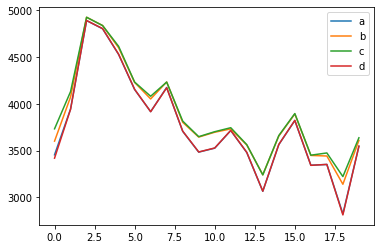

In [55]:
MLY=[3602.284,4074.673,4927.502,4838.476,4601.583,4229.942,4053.547,4235.099,3803.772,3645.534,3697.578,3732.959,3560.779,3242.321,3656.348,3892.750,3449.239,3443.320,3141.161,3610.229]
plt.plot(LX,label="a")
plt.plot(MLY,label="b")
plt.plot(Normal,label="c")
plt.plot(SD,label="d")
plt.legend()

In [44]:
A.aic

3610.2290280582133

In [13]:
print(A.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      NENTRY                Number of Observations:        2420
Mean dependent var  :     -0.0000                Number of Variables   :          96
S.D. dependent var  :      1.0002                Degrees of Freedom    :        2324
Pseudo R-squared    :      0.6523
Spatial Pseudo R-squared:  0.6519
Sigma-square ML     :       0.348                Log likelihood        :   -2157.503
S.E of regression   :       0.590                Akaike info criterion :    4507.006
                                                 Schwarz criterion     :    5062.992

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

In [49]:
##########   LAGGED Y GM
SARY=[]
##########   LAGGED Y
cols_m=['YEAR', 'ZIP_2', 'NGROUP', 'NENTRY', 'LOCATION_Q', 'REGIONAL_I', 'FIRM_SIZE_', 'BUSINESS_C', 'AVG_WAGE', 'POP_DEN', 'POP_INC', 'POP_BLACK', 'POP_HISP', 'POP_WORK_A', 'POP_MALE', 'COLLEGE_CO', 'HIGHSCHOOL', 'UNEMPLOYME', 'NAIRPORTS', 'MED_INC', 'MED_VALUE', 'HOME_OWNER']
gdf=gpd.read_file(r"/Users/shagunmittal/Documents/research/Spatial/20_finalvars/20_finalvars.shp")
ngroups=20
initial=1990
ncomponents=3
data1=np.zeros(((len(cols_m)-9),2011-initial+1))
noweights=["POP_MALE"]
for cnt in range(2,ngroups+1):
    noweights.append("GG"+str(cnt))
for cnt in range(2,ngroups+1):
    cols_m.append("GG"+str(cnt))
for cnt in range(1,ngroups+1):
    for cnt2 in range(1,ncomponents+1):
        cols_m.append("F"+str(cnt)+str(cnt2))
drop=["MED_INC","POP_MALE","COLLEGE_CO"]
for cnt in drop:
    cols_m.remove(cnt)
for year in range(1992,2012):
    print(year)
    cols=cols_m
    gdf1=gdf[gdf["YEAR"]==year]
    W=lps.weights.Queen.from_dataframe(gdf1,silence_warnings=True)
    for cnt in range(0,gdf1.shape[0]):
        grp = gdf1["NGROUP"].values[cnt]
        Neigh = W.neighbors[cnt]
        temp=[]
        for cnt2 in range(0,len(Neigh)):
            grp2 = gdf1["NGROUP"].values[Neigh[cnt2]]
            if grp!=grp2:
                temp.append(Neigh[cnt2])
        for cnt2 in temp:
            (W.neighbors[cnt]).remove(cnt2)
    cneighbors=W.neighbors
    cweights = {}
    for key, value in cneighbors.items():
        cweights[key] = (np.ones_like(value)/len(value)).tolist()
    w2 = lps.weights.W(cneighbors, cweights)
    ##### AVG_WAGE 9th
    exp=cols[3]+"~"
    for cnt in range(4,8):
        exp=exp+cols[cnt]+"+"
    n=len(cols)
    for cnt in range(8,n):
        if cols[cnt] in drop:
            continue
        if cnt<n-1:
            exp=exp+cols[cnt]+"+"
        else:
            exp=exp+cols[cnt]
    gdf99=gdf1
    df99=pd.DataFrame()
    df99["YEAR"]=gdf99["YEAR"].values
    for column in cols:
        if column.startswith("GG"):
            continue
        if column.startswith("F"):
            if column!="FIRM_SIZE_":
                continue
        x=gdf99[[column]].values
        st_scaler=preprocessing.StandardScaler()
        x_st=st_scaler.fit_transform(x)
        df99[column]=pd.DataFrame(x_st)
    for cnt in range(2,ngroups+1):
        n="GG"+str(cnt)
        df99[n]=gdf99[n].values
    for cnt in range(1,ngroups+1):
        for cnt2 in range(1,ncomponents+1):
            n="F"+str(cnt)+str(cnt2)
            df99[n]=gdf99[n].values
    if exp.endswith("+"):
        exp=exp[:len(exp)-1]
    y_full1, X_full1 = dmatrices(exp, df99, return_type='dataframe')
    X_full1=X_full1.drop(["Intercept"], axis=1)
    nameX=[]
    for i in X_full1.columns:
        nameX.append(i)
    A=spreg.GM_Lag(y_full1.values, X_full1.values, w=w2, spat_diag=True,name_y="NENTRY", name_x=nameX)
    SARY.append(spreg.diagnostics.akaike(A))
    print(A.summary)

1992


/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)


Exception: power expansion will not converge, check model specification and that weight are less than 1

In [15]:
SARY

[4520.528462974073]

In [16]:
print(A.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      NENTRY                Number of Observations:        2420
Mean dependent var  :     -0.0000                Number of Variables   :          96
S.D. dependent var  :      1.0002                Degrees of Freedom    :        2324
Pseudo R-squared    :      0.6498
Spatial Pseudo R-squared:  0.6509

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT       0.1971463       0.0577562       3.4134217       0.0006415
          LOCATION_Q       0.0354873       0.0133401       2.6602027       0.0078094
          REGIONAL_I      -0.1617040       0.0153114     -1

/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:770: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      NENTRY                Number of Observations:        2420
Mean dependent var  :      0.0000                Number of Variables   :         125
S.D. dependent var  :      1.0002                Degrees of Freedom    :        2295
Pseudo R-squared    :      0.7802
Spatial Pseudo R-squared:  0.7756
Sigma-square ML     :       0.220                Log likelihood        :   -1608.607
S.E of regression   :       0.469                Akaike info criterion :    3467.214
                                                 Schwarz criterion     :    4191.155

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

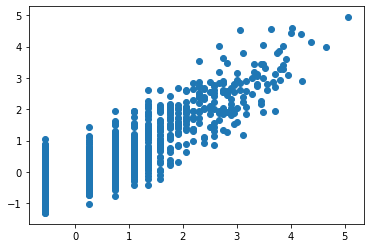

In [3]:
##########   LAGGED X MODEL + LAG_Y
# SD=[]
cols_m=['YEAR', 'ZIP_2', 'NGROUP', 'NENTRY', 'LOCATION_Q', 'REGIONAL_I', 'FIRM_SIZE_', 'BUSINESS_C', 'AVG_WAGE', 'POP_DEN', 'POP_INC', 'POP_BLACK', 'POP_HISP', 'POP_WORK_A', 'POP_MALE', 'COLLEGE_CO', 'HIGHSCHOOL', 'UNEMPLOYME', 'NAIRPORTS', 'MED_INC', 'MED_VALUE', 'HOME_OWNER']
gdf=gpd.read_file(r"/Users/shagunmittal/Documents/research/Spatial/20_finalvars/20_finalvars.shp")
ngroups=20
initial=1990
ncomponents=3
data1=np.zeros(((len(cols_m)-9),2011-initial+1))
noweights=["REGIONAL_I","FIRM_SIZE_","BUSINESS_C"]
for cnt in range(2,ngroups+1):
    noweights.append("GG"+str(cnt))
for cnt in range(2,ngroups+1):
    cols_m.append("GG"+str(cnt))
noweights_factors=[2,3]
for cnt in range(1,ngroups+1):
    for cnt2 in range(1,ncomponents+1):
        cols_m.append("F"+str(cnt)+str(cnt2))
        if cnt2 in noweights_factors:
            noweights.append("F"+str(cnt)+str(cnt2))
drop=["MED_INC","POP_MALE","COLLEGE_CO"]
for cnt in drop:
    cols_m.remove(cnt)
for year in range(1992,1993):
    cols=cols_m
    gdf1=gdf[gdf["YEAR"]==year]
    W=lps.weights.Queen.from_dataframe(gdf1)
    for cnt in range(0,gdf1.shape[0]):
        grp = gdf1["NGROUP"].values[cnt]
        Neigh = W.neighbors[cnt]
        temp=[]
        for cnt2 in range(0,len(Neigh)):
            grp2 = gdf1["NGROUP"].values[Neigh[cnt2]]
            if grp!=grp2:
                temp.append(Neigh[cnt2])
        for cnt2 in temp:
            (W.neighbors[cnt]).remove(cnt2)
    cneighbors=W.neighbors
    cweights = {}
    for key, value in cneighbors.items():
        cweights[key] = (np.ones_like(value)/len(value)).tolist()
    w2 = lps.weights.W(cneighbors, cweights)
    ##### AVG_WAGE 9th
    exp=cols[3]+"~"
#     for cnt in range(4,8):
#         exp=exp+cols[cnt]+"+"
    n=len(cols)
    for cnt in range(4,n):
        if cols[cnt].startswith("W_"):
            continue
        if cols[cnt] in drop:
            continue
        exp=exp+cols[cnt]+"+"
        if cols[cnt] in noweights:
            continue
        gdf1["W_"+cols[cnt]]=lps.weights.lag_spatial(w2, gdf1[cols[cnt]].values)
        corr_val=gdf1["W_"+cols[cnt]].corr(gdf1[cols[cnt]])
        if abs(corr_val)<0.7:
            if cnt<n-1:
                exp=exp+"W_"+cols[cnt]+"+"
            else:
                exp=exp+"W_"+cols[cnt]
            cols.append("W_"+cols[cnt])
    ############  Print and Check exp value before proceeding
    gdf99=gdf1
    df99=pd.DataFrame()
    df99["YEAR"]=gdf99["YEAR"].values
    for column in cols:
        if column.startswith("GG"):
            continue
        if column.startswith("F"):
            if column!="FIRM_SIZE_":
                continue
        if column.startswith("W_F"):
            if column!="W_FIRM_SIZE_":
                continue
        x=gdf99[[column]].values
        min_max_scaler=preprocessing.StandardScaler()
        x_scaled=min_max_scaler.fit_transform(x)
        df99[column]=pd.DataFrame(x_scaled)
    for cnt in range(2,ngroups+1):
        n="GG"+str(cnt)
        df99[n]=gdf99[n].values
    for cnt in range(1,ngroups+1):
        for cnt2 in range(1,ncomponents+1):
            n="F"+str(cnt)+str(cnt2)
            df99[n]=gdf99[n].values
            if n in noweights:
                continue
            df99["W_"+n]=gdf99["W_"+n].values
    if exp.endswith("+"):
        exp=exp[:len(exp)-1]
    y_full1, X_full1 = dmatrices(exp, df99, return_type='dataframe')
    X_full1=X_full1.drop(["Intercept"], axis=1)
    nameX=[]
    for i in X_full1.columns:
        nameX.append(i)
    A=spreg.ML_Lag(y_full1.values, X_full1.values, w=w2, spat_diag=True,name_y="NENTRY", name_x=nameX)
#     SD.append(spreg.diagnostics.akaike(A))
#     SD.append(A.aic)
    print(A.summary)
    plt.scatter(y_full1,A.predy)

In [2]:
##########   LAGGED X MODEL + LAG_Y WITHOUT NETWORK
cols_m=['YEAR', 'ZIP_2', 'NGROUP', 'NENTRY', 'LOCATION_Q', 'REGIONAL_I', 'FIRM_SIZE_', 'BUSINESS_C', 'AVG_WAGE', 'POP_DEN', 'POP_INC', 'POP_BLACK', 'POP_HISP', 'POP_WORK_A', 'POP_MALE', 'COLLEGE_CO', 'HIGHSCHOOL', 'UNEMPLOYME', 'NAIRPORTS', 'MED_INC', 'MED_VALUE', 'HOME_OWNER']
gdf=gpd.read_file(r"/Users/shagunmittal/Documents/research/Spatial/20_finalvars/20_finalvars.shp")
ngroups=20
initial=1990
ncomponents=3
data1=np.zeros(((len(cols_m)-9),2011-initial+1))
noweights=["REGIONAL_I","FIRM_SIZE_","BUSINESS_C"]
for cnt in range(2,ngroups+1):
    noweights.append("GG"+str(cnt))
for cnt in range(2,ngroups+1):
    cols_m.append("GG"+str(cnt))
drop=["MED_INC","POP_MALE","COLLEGE_CO"]
for cnt in drop:
    cols_m.remove(cnt)
for year in range(1992,1993):
    cols=cols_m
    gdf1=gdf[gdf["YEAR"]==year]
    W=lps.weights.Queen.from_dataframe(gdf1)
    for cnt in range(0,gdf1.shape[0]):
        grp = gdf1["NGROUP"].values[cnt]
        Neigh = W.neighbors[cnt]
        temp=[]
        for cnt2 in range(0,len(Neigh)):
            grp2 = gdf1["NGROUP"].values[Neigh[cnt2]]
            if grp!=grp2:
                temp.append(Neigh[cnt2])
        for cnt2 in temp:
            (W.neighbors[cnt]).remove(cnt2)
    cneighbors=W.neighbors
    cweights = {}
    for key, value in cneighbors.items():
        cweights[key] = (np.ones_like(value)/len(value)).tolist()
    w2 = lps.weights.W(cneighbors, cweights)
    ##### AVG_WAGE 9th
    exp=cols[3]+"~"
#     for cnt in range(4,8):
#         exp=exp+cols[cnt]+"+"
    n=len(cols)
    for cnt in range(4,n):
        if cols[cnt].startswith("W_"):
            continue
        if cols[cnt] in drop:
            continue
        exp=exp+cols[cnt]+"+"
        if cols[cnt] in noweights:
            continue
        gdf1["W_"+cols[cnt]]=lps.weights.lag_spatial(w2, gdf1[cols[cnt]].values)
        corr_val=gdf1["W_"+cols[cnt]].corr(gdf1[cols[cnt]])
        if abs(corr_val)<0.7:
            if cnt<n-1:
                exp=exp+"W_"+cols[cnt]+"+"
            else:
                exp=exp+"W_"+cols[cnt]
            cols.append("W_"+cols[cnt])
    ############  Print and Check exp value before proceeding
    gdf99=gdf1
    df99=pd.DataFrame()
    df99["YEAR"]=gdf99["YEAR"].values
    for column in cols:
        if column.startswith("GG"):
            continue
        x=gdf99[[column]].values
        min_max_scaler=preprocessing.StandardScaler()
        x_scaled=min_max_scaler.fit_transform(x)
        df99[column]=pd.DataFrame(x_scaled)
    for cnt in range(2,ngroups+1):
        n="GG"+str(cnt)
        df99[n]=gdf99[n].values
    if exp.endswith("+"):
        exp=exp[:len(exp)-1]
    y_full1, X_full1 = dmatrices(exp, df99, return_type='dataframe')
    X_full1=X_full1.drop(["Intercept"], axis=1)
    nameX=[]
    for i in X_full1.columns:
        nameX.append(i)
    B=spreg.ML_Lag(y_full1.values, X_full1.values, w=w2, spat_diag=True,name_y="NENTRY", name_x=nameX)

/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:770: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


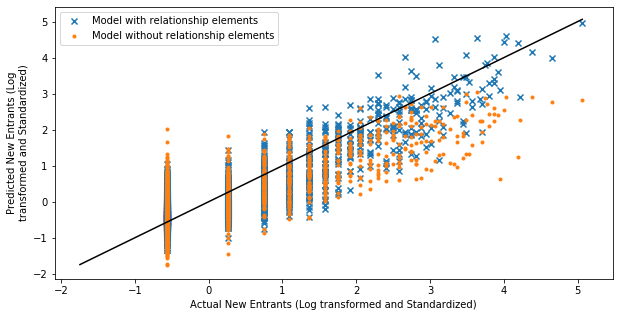

In [5]:
X=[min(float(np.min(y_full1)),np.min(A.predy),np.min(B.predy)),max(float(np.max(y_full1)),np.max(A.predy),np.max(B.predy))]
plt.plot(X,X, color="black")
plt.scatter(y_full1,A.predy, label="Model with relationship elements",marker="x")
plt.scatter(y_full1,B.predy, label="Model without relationship elements",marker=".")
plt.xlabel("Actual New Entrants (Log transformed and Standardized)")
plt.ylabel("Predicted New Entrants (Log\ntransformed and Standardized)")
# plt.title("Predicted vs Actual Number of new entrants")
plt.gcf().set_size_inches(10,5,plt.gcf().get_size_inches()[1])
plt.legend()
plt.savefig("/Users/shagunmittal/OneDrive - purdue.edu/research_paper1/6b.eps",format="eps",bbox_inches="tight")

In [21]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(y_full1.values[y_full1>2],A.predy[y_full1>2]))
print(mean_squared_error(y_full1.values[y_full1>2],B.predy[y_full1>2]))
# y_full1[y_full1>1]

0.5310477884106047
1.6371266056744862


In [189]:
x=float(A.betas[1])
x-((1.96*A.std_err[1]))
data1=[[],[],[]]
nameX2=["CONSTANT"]+nameX+["W_NENTRY"]
# data1[0].append(np.array(nameX))
# data1[0].append(np.array(nameX))
data1[0]=data1[0]+nameX
data1[1]=data1[1]+nameX
data1[2]=(1.96*np.reshape(A.std_err,(len(A.std_err),1)))
data1[2]

array([[0.09193897],
       [0.02119266],
       [0.02565031],
       [0.02323013],
       [0.03048581],
       [0.03839819],
       [0.03710753],
       [0.06712727],
       [0.0227738 ],
       [0.02693651],
       [0.0287241 ],
       [0.04020223],
       [0.02732887],
       [0.03080762],
       [0.03648117],
       [0.03201502],
       [0.03210625],
       [0.05159339],
       [0.04105554],
       [0.02617325],
       [0.02617386],
       [0.03856945],
       [0.03544398],
       [0.04756275],
       [0.12779695],
       [0.12922896],
       [0.12853529],
       [0.13260384],
       [0.1292973 ],
       [0.13228696],
       [0.12747762],
       [0.12824054],
       [0.12786608],
       [0.12892268],
       [0.12910589],
       [0.13008435],
       [0.1282959 ],
       [0.13598578],
       [0.12984592],
       [0.15151791],
       [0.15154765],
       [0.13681557],
       [0.13441067],
       [0.02344156],
       [0.03281961],
       [0.0214235 ],
       [0.07603122],
       [0.021

In [270]:
##########   LAGGED X MODEL + LAG_Y + saving variables
SD=[]
cols_m=['YEAR', 'ZIP_2', 'NGROUP', 'NENTRY', 'LOCATION_Q', 'REGIONAL_I', 'FIRM_SIZE_', 'BUSINESS_C', 'AVG_WAGE', 'POP_DEN', 'POP_INC', 'POP_BLACK', 'POP_HISP', 'POP_WORK_A', 'POP_MALE', 'COLLEGE_CO', 'HIGHSCHOOL', 'UNEMPLOYME', 'NAIRPORTS', 'MED_INC', 'MED_VALUE', 'HOME_OWNER']
gdf=gpd.read_file(r"/Users/shagunmittal/Documents/research/Spatial/20_finalvars/20_finalvars.shp")
ngroups=20
initial=1990
ncomponents=3
data1=[[],[],[]]
noweights=["REGIONAL_I","FIRM_SIZE_","BUSINESS_C"]
for cnt in range(2,ngroups+1):
    noweights.append("GG"+str(cnt))
for cnt in range(2,ngroups+1):
    cols_m.append("GG"+str(cnt))
noweights_factors=[2,3]
for cnt in range(1,ngroups+1):
    for cnt2 in range(1,ncomponents+1):
        cols_m.append("F"+str(cnt)+str(cnt2))
        if cnt2 in noweights_factors:
            noweights.append("F"+str(cnt)+str(cnt2))
drop=["MED_INC","POP_MALE","COLLEGE_CO"]
arr_years=np.array([])
arr_var=np.array([])
arr_beta=np.array([])
arr_err=np.array([])
arr_pval=np.array([])
for cnt in drop:
    cols_m.remove(cnt)
for year in range(1992,2012):
    print(year)
    cols=cols_m
    gdf1=gdf[gdf["YEAR"]==year]
    W=lps.weights.Queen.from_dataframe(gdf1)
    for cnt in range(0,gdf1.shape[0]):
        grp = gdf1["NGROUP"].values[cnt]
        Neigh = W.neighbors[cnt]
        temp=[]
        for cnt2 in range(0,len(Neigh)):
            grp2 = gdf1["NGROUP"].values[Neigh[cnt2]]
            if grp!=grp2:
                temp.append(Neigh[cnt2])
        for cnt2 in temp:
            (W.neighbors[cnt]).remove(cnt2)
    cneighbors=W.neighbors
    cweights = {}
    for key, value in cneighbors.items():
        cweights[key] = (np.ones_like(value)/len(value)).tolist()
    w2 = lps.weights.W(cneighbors, cweights)
    ##### AVG_WAGE 9th
    exp=cols[3]+"~"
#     for cnt in range(4,8):
#         exp=exp+cols[cnt]+"+"
    n=len(cols)
    for cnt in range(4,n):
        if cols[cnt].startswith("W_"):
            continue
        if cols[cnt] in drop:
            continue
        exp=exp+cols[cnt]+"+"
        if cols[cnt] in noweights:
            continue
        gdf1["W_"+cols[cnt]]=lps.weights.lag_spatial(w2, gdf1[cols[cnt]].values)
        corr_val=gdf1["W_"+cols[cnt]].corr(gdf1[cols[cnt]])
        if abs(corr_val)<0.7:
            if cnt<n-1:
                exp=exp+"W_"+cols[cnt]+"+"
            else:
                exp=exp+"W_"+cols[cnt]
            cols.append("W_"+cols[cnt])
    ############  Print and Check exp value before proceeding
    gdf99=gdf1
    df99=pd.DataFrame()
    df99["YEAR"]=gdf99["YEAR"].values
    for column in cols:
        if column.startswith("GG"):
            continue
        if column.startswith("F"):
            if column!="FIRM_SIZE_":
                continue
        if column.startswith("W_F"):
            if column!="W_FIRM_SIZE_":
                continue
        x=gdf99[[column]].values
        min_max_scaler=preprocessing.StandardScaler()
        x_scaled=min_max_scaler.fit_transform(x)
        df99[column]=pd.DataFrame(x_scaled)
    for cnt in range(2,ngroups+1):
        n="GG"+str(cnt)
        df99[n]=gdf99[n].values
    for cnt in range(1,ngroups+1):
        for cnt2 in range(1,ncomponents+1):
            n="F"+str(cnt)+str(cnt2)
            df99[n]=gdf99[n].values
            if n in noweights:
                continue
            df99["W_"+n]=gdf99["W_"+n].values
    if exp.endswith("+"):
        exp=exp[:len(exp)-1]
    y_full1, X_full1 = dmatrices(exp, df99, return_type='dataframe')
    X_full1=X_full1.drop(["Intercept"], axis=1)
    nameX=[]
    for i in X_full1.columns:
        nameX.append(i)
    A=spreg.ML_Lag(y_full1.values, X_full1.values, w=w2, spat_diag=True,name_y="NENTRY", name_x=nameX)
    SD.append(A.aic)
#     print(A.summary)
    yearstemp=year*np.ones((len(A.betas),1))
    varstemp=["CONSTANT"]+nameX+["W_NENTRY"]
    betastemp=np.reshape(A.betas,(len(A.betas),1))
    errorstemp=(1.96*np.reshape(A.std_err,(len(A.std_err),1)))
    p_valstemp=np.zeros((len(A.z_stat),1))
    for cnt in range(0,len(A.z_stat)):
        p_valstemp[cnt]=A.z_stat[cnt][1]
    if arr_years.size>0:
        arr_years=np.concatenate((arr_years,yearstemp),axis=0)
        arr_var=np.concatenate((arr_var,varstemp),axis=0)
        arr_beta=np.concatenate((arr_beta,betastemp),axis=0)
        arr_err=np.concatenate((arr_err,errorstemp),axis=0)
        arr_pval=np.concatenate((arr_pval,p_valstemp),axis=0)
        
    else:
        arr_years=yearstemp
        arr_var=varstemp
        arr_beta=betastemp
        arr_err=errorstemp
        arr_pval=p_valstemp
Results=pd.DataFrame(arr_years,columns=["YEAR"])
Results["YEAR"]=arr_years
Results["VARIABLE"]=arr_var
Results["BETAS"]=arr_beta
Results["ERROR"]=arr_err
Results["PVALUE"]=arr_pval

1992


/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:770: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


1993


/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:770: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


1994


/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:770: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


1995


/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:770: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


1996


/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:770: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


1997


/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:770: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


1998


/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:770: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


1999


/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:770: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


2000


/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:770: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


2001


/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:770: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


2002


/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:770: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


2003


/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:770: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


2004


/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:770: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


2005


/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:770: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


2006


/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:770: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


2007


/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:770: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


2008


/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:770: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


2009


/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:770: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


2010


/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:770: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


2011


/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 20 disconnected components.
  warnings.warn(message)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Users/shagunmittal/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:770: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


In [271]:
Results.to_csv(r"/Users/shagunmittal/Documents/research/Spatial/finalmodelparams.csv")

In [56]:
(SD)

[3420.154480211595,
 3942.8100144611867,
 4892.871345258358,
 4805.92882539622,
 4531.624002696561,
 4156.168414025049,
 3917.17336033077,
 4172.963151886484,
 3709.458869113233,
 3486.4631101329646,
 3529.13212934821,
 3716.909990038962,
 3482.426177370332,
 3066.827506190659,
 3567.219978257132,
 3824.599316265036,
 3343.470793811562,
 3353.237513046586,
 2813.1211155211167,
 3548.647595607768]

In [272]:
print(SD)

[3467.21417148995, 3983.0075849257846, 4926.472478338737, 4808.279294307798, 4541.103365648976, 4168.602190635475, 3940.8463402066673, 4163.846750292445, 3765.6497079458413, 3565.6163237242527, 3655.570805324293, 3722.5965615240684, 3567.2260954837902, 3191.5035103303117, 3641.087825484175, 3864.2591456248533, 3411.3992993676684, 3426.966984338727, 3007.293973408795, 3598.156823364118]


In [273]:
print(A.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      NENTRY                Number of Observations:        2420
Mean dependent var  :      0.0000                Number of Variables   :         125
S.D. dependent var  :      1.0002                Degrees of Freedom    :        2295
Pseudo R-squared    :      0.7666
Spatial Pseudo R-squared:  0.7662
Sigma-square ML     :       0.233                Log likelihood        :   -1674.078
S.E of regression   :       0.483                Akaike info criterion :    3598.157
                                                 Schwarz criterion     :    4322.097

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

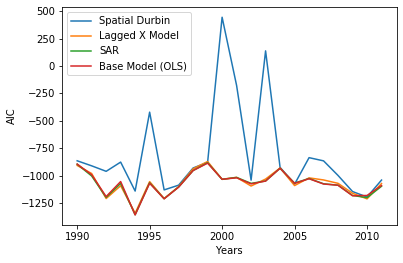

In [100]:
X=np.linspace(1990,2011,2011-1990+1)
plt.plot(X,SD, label="Spatial Durbin")
plt.plot(X,LX, label="Lagged X Model")
plt.plot(X,SARY, label="SAR")
plt.plot(X,Normal, label="Base Model (OLS)")
plt.xlabel("Years")
plt.ylabel("AIC")
plt.legend()